![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

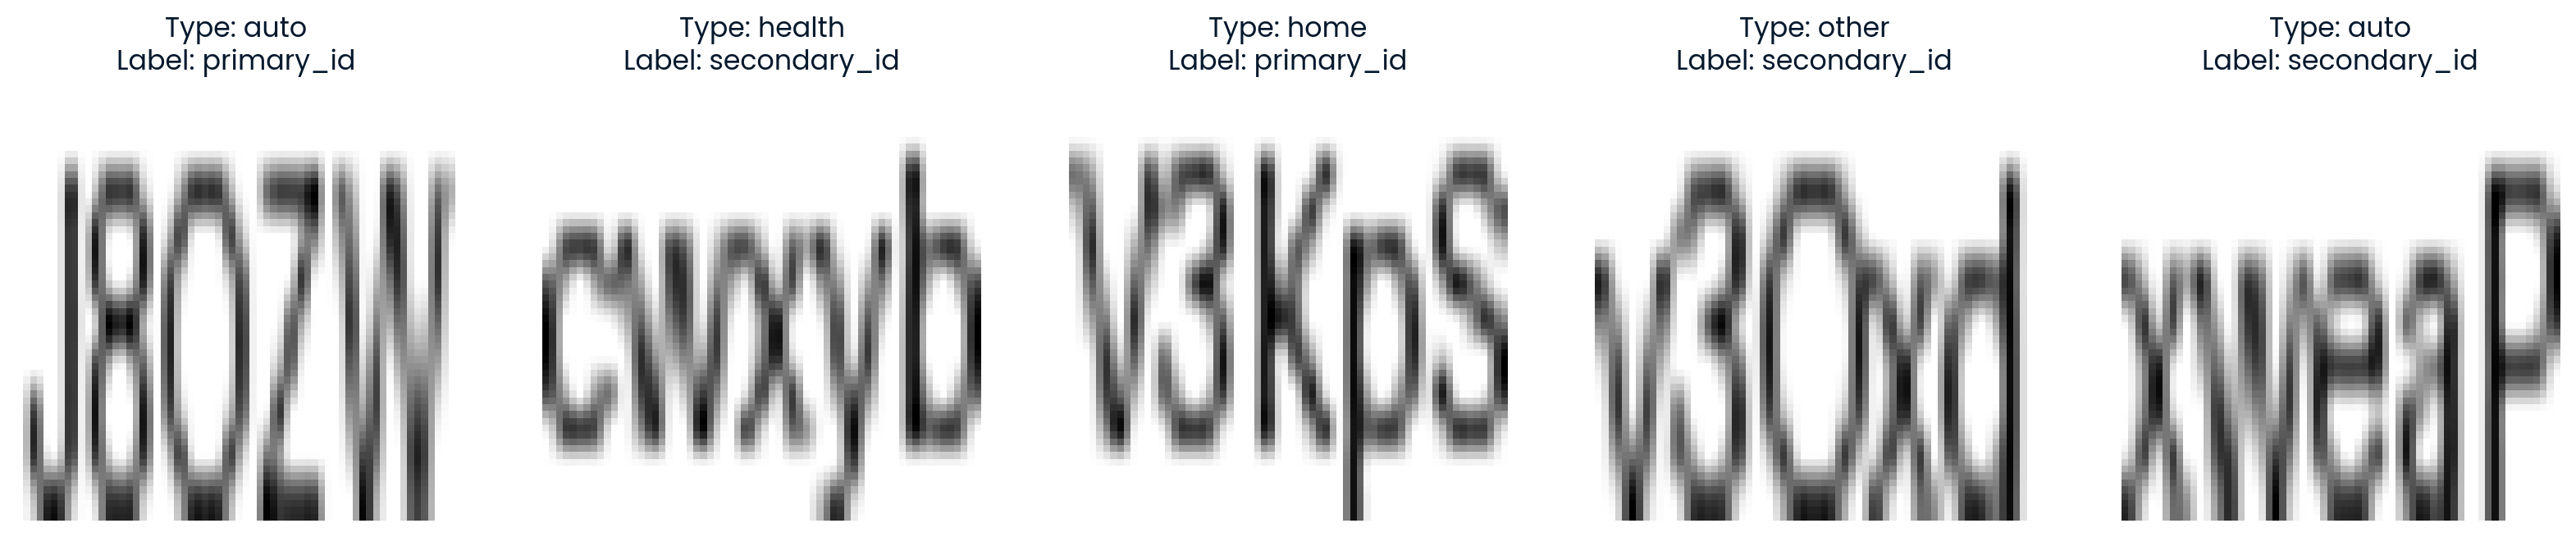

In [9]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [10]:
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Image processing branch
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (16, 64, 64)
            nn.MaxPool2d(2),                             # (16, 32, 32)
            nn.ReLU(),
            nn.Flatten(),                                # 16*32*32 = 16384
            nn.Linear(16384, 128)                        # Compress to 128 features
        )
        # Insurance type processing branch
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),  # 5 insurance types → 10 features
            nn.ReLU()
        )
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 2)  # Binary output for primary/secondary ID
        )

    def forward(self, x_image, x_type):
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)
        x = torch.cat((x_image, x_type), dim=1)
        return self.classifier(x)

# Initialize model, optimizer, and loss function
model = OCRModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Data loading and training loop
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for (images, types), labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, types)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 6.7652
Epoch 2, Loss: 4.9072
Epoch 3, Loss: 3.0116
Epoch 4, Loss: 1.2174
Epoch 5, Loss: 0.8900
Epoch 6, Loss: 0.6934
Epoch 7, Loss: 0.5463
Epoch 8, Loss: 0.6039
Epoch 9, Loss: 0.7219
Epoch 10, Loss: 0.7273
